![](./images/bqom+vertex+llm.png)

## Define Variable

In [1]:
PROJECT_ID="vtxdemos"
STAGING_BUCKET="gs://vtxdemos-staging"
TRAIN_IMAGE=f"gcr.io/{PROJECT_ID}/llm_ga_train:v1"

## Analytics

In [2]:
from google.cloud import bigquery

client=bigquery.Client("vtxdemos")
query="SELECT * FROM `vtxdemos.public.train_dataset`"
train_df=client.query(query).to_dataframe()

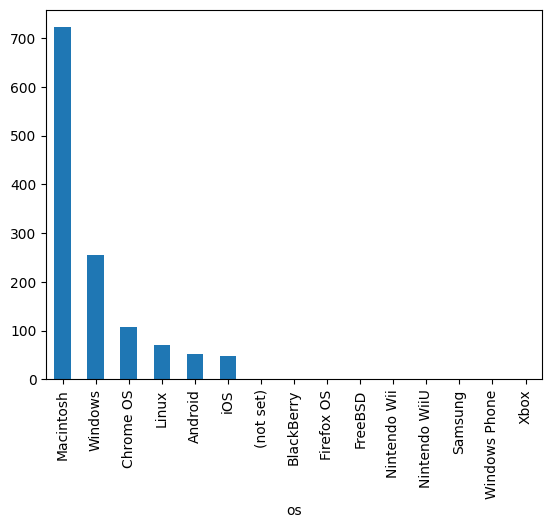

In [3]:
from matplotlib import pyplot as plt

train_df.groupby('os').sum()['label'].sort_values(ascending=False).plot(kind='bar')
plt.show()

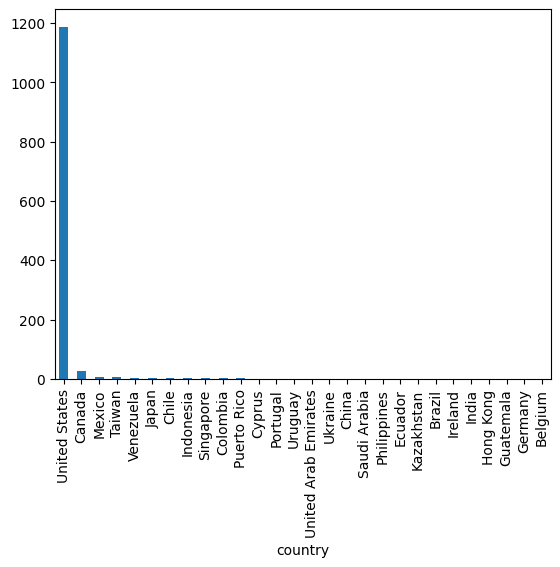

In [4]:
from matplotlib import pyplot as plt
new_df = train_df[train_df['label']!=0]
new_df.groupby('country').sum().sort_values(by='label', ascending=False)['label'].plot(kind='bar')
plt.show()

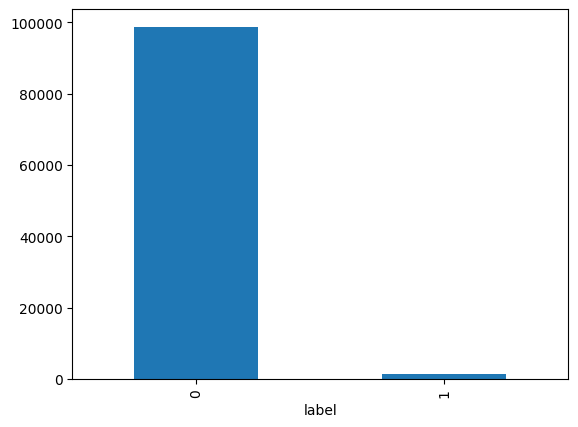

In [5]:
train_df['label'].value_counts().plot(kind='bar')
plt.show()

## Training Code (PyTorch Tabular Data)

In [12]:
%%writefile train.py

import os
import argparse
from ai.vertex import bq_load, train

parser = argparse.ArgumentParser()
parser.add_argument("--train_data", help="Name of the training dataset in format bq: project.dataset.table")
parser.add_argument("--eval_data", help="Name of the evaluation dataset in format bq: project.dataset.table")
args = parser.parse_args()

## BigQuery Omni Loading Data from AWS
train_df, eval_df = bq_load(args.train_data, args.eval_data)
train(train_df, eval_df)

Overwriting train.py


In [ ]:
%%writefile Dockerfile
FROM pytorch/pytorch:1.12.1-cuda11.3-cudnn8-devel

COPY . .
RUN pip install google-cloud-bigquery
RUN pip install db-dtypes
RUN pip install pandas
RUN pip install pytorch_tabular[extra]
RUN pip install gcsfs

ENTRYPOINT ["python", "train.py"]

## Container Build and Push to GCR

In [ ]:
!gcloud builds submit -t $TRAIN_IMAGE .

## Vertex AI Custom Training

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, staging_bucket=STAGING_BUCKET)

worker_pool_specs = [
        {
            "machine_spec": {
                "machine_type": "a2-highgpu-1g",
                "accelerator_type": "NVIDIA_TESLA_A100",
                "accelerator_count": 1,
            },
            "replica_count": 1,
            "container_spec": {
                "image_uri": TRAIN_IMAGE,
                "command": [],
                "args": [
                    "--train_data=vtxdemos.bq_omni_demo.train_dataset",
                    "--eval_data=vtxdemos.bq_omni_demo.eval_dataset"
                    ],
            },
        }
    ]

my_job = aiplatform.CustomJob(
    display_name='pytorch_tabular_custom',
    worker_pool_specs=worker_pool_specs,
)

my_job.run()

In [6]:
from ai.nlp import llm, embedding
from google.cloud import bigquery
from google.cloud import aiplatform

client = bigquery.Client(project=PROJECT_ID)
pred_df = client.query("SELECT * FROM `vtxdemos.public.pred_data`").to_dataframe()

In [31]:
from langchain.document_loaders.dataframe import DataFrameLoader
from langchain.indexes import VectorstoreIndexCreator

loader = DataFrameLoader(pred_df[pred_df["prediction"]!=0].groupby("country").sum().reset_index()[["country", "prediction"]], page_content_column="prediction")
bigquery_prediction_index = VectorstoreIndexCreator(embedding=embedding, vectorstore_kwargs={
  'persist_directory': 'ai/datastore/purchase_per_country'
}).from_loaders([loader])

Using embedded DuckDB with persistence: data will be stored in: ai/datastore/purchase_per_country


## Prediction Dataset (Aggregated)

In [33]:
pred_df[pred_df["prediction"]!=0].groupby("country").sum().reset_index()[["country", "prediction"]]

,country,prediction
0,St. Lucia,2
1,United States,30


In [32]:
from langchain.chains import RetrievalQA, ConversationChain, SimpleSequentialChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

question = "How many purchases has United States?"

retrieval_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="map_reduce",
    retriever=bigquery_prediction_index.vectorstore.as_retriever())
retrieval_chain({"query": question}, return_only_outputs=True)

Chroma collection langchain contains fewer than 4 elements.
Chroma collection langchain contains fewer than 3 elements.
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors


{'result': 'The United States has made 30 purchases.'}